In [1]:
import pandas as pd
import numpy as np
import re
import os
from itertools import groupby
from operator import itemgetter
import warnings
import pickle
from Bio import Seq
from Bio import SeqIO
import pysam
import itertools
import scipy
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/lustre/user/lulab/doushq/wuxk/software/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def hamming(s1,s2): return sum(a!=b for a,b in zip(s1,s2))  

MW_dict = {"G": 57.02147, 
            "A" : 71.03712, 
            "S" : 87.03203, 
            "P" : 97.05277, 
            "V" : 99.06842, 
            "T" : 101.04768, 
            "I" : 113.08407, 
            "L" : 113.08407, 
            "N" : 114.04293, 
            "D" : 115.02695, 
            "Q" : 128.05858, 
            "K" : 128.09497, 
            "E" : 129.0426, 
            "M" : 131.04049, 
            "H" : 137.05891,
            "F" : 147.06842, 
            "R" : 156.10112, 
            "C" : 160.030654, #CamCys
            "Y" : 163.0633,
            "W" : 186.07932,
            }# Molecular mass of amino acid residues

def get_inverted_codon_table():
    ct = get_codon_table()
    inv_codon_table = {}
    for k, v in ct.items():
        inv_codon_table[v] = inv_codon_table.get(v, [])
        inv_codon_table[v].append(k)
    return inv_codon_table

def get_codon_table():
    return dict(zip(codons, amino_acids))

def prepare_count_matrix(df):

    matrix = pd.DataFrame(data = 0, index = codons, columns=list('ACDEFGHKLMNPQRSTVWY'),dtype=float)
    df = df[df['DP decoy']!='+']
    df = df[pd.notnull(df['codon'])] # filter 
    df['codon'] = df['codon'].map(lambda x: x.replace('T','U'))
    for label in matrix.index:
        if codon_table[label] == '*':
            matrix.loc[label] = float('NaN')
        for col in matrix.columns:
            if (label in inverted_codon_table[col]) or (codon_table[label] +' to '+col in exact_PTM_spec_list):
                matrix.loc[label, col] = float('NaN')
    subs_agg = pd.DataFrame(df.groupby(['protein','position','origin','destination','codon']).groups.keys(), columns=['protein','position','origin','destination','codon'])

    for x, l in subs_agg.groupby(['codon', 'destination']).groups.items():
        codon, destination = x
        if (codon in matrix.index) and pd.notnull(matrix.loc[codon,destination]):
            matrix.loc[codon,destination] = len(l)
    matrix.rename(columns={"L": "I/L"},inplace=True)
    return matrix
    
def probe_mismatch(codon1, codon2, pos, spec):
    origin, destination = spec
    for i in range(3):
        if i == pos:
            if codon1[i] != origin or codon2[i] != destination:
                return False
        else:
            if codon1[i] != codon2[i]:
                return False
    return True

bases = 'UCAG'
codons = [a+b+c for a in bases for b in bases for c in bases]

amino_acids = 'FFLLSSSSYY**CC*WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'
RC = {'A':'U', 'C':'G', 'G':'C', 'U':'A'}

codon_table = get_codon_table()
inverted_codon_table = get_inverted_codon_table()
inverted_codon_table['L'] = inverted_codon_table['L'] + inverted_codon_table['I']
tol = 0.005

aas_sorted_by_mass = [i[0] for i in sorted(MW_dict.items(),key=lambda x:x[1])]
danger_mods = pd.read_pickle('danger_mods')
exact_PTM_spec = pd.DataFrame(index = aas_sorted_by_mass,
                              columns = aas_sorted_by_mass,
                              dtype = int)

for aa1 in MW_dict.keys():
    for aa2 in MW_dict.keys():
        delta_m = MW_dict[aa2] - MW_dict[aa1]
        exact_PTM_spec.loc[aa1,aa2]=len(danger_mods[(danger_mods['delta_m']<delta_m + 0.0005) & (danger_mods['delta_m']>delta_m - 0.0005) & (danger_mods['site']==aa1)]) > 0

exact_PTM_spec_list = [str(i) + ' to ' + str(j) for i in aas_sorted_by_mass for j in  aas_sorted_by_mass if exact_PTM_spec.loc[i,j]] 

mask = pd.DataFrame(data = False,
                    index = codons,
                    columns = list('ACDEFGHKLMNPQRSTVWY'),
                    dtype = float)

for label in codons:
    near_cognates = np.array([hamming(i,label)==1 for i in codons])
    reachable_aa = set(np.array(list(amino_acids))[near_cognates])
    mask.loc[label] =[i in reachable_aa for i in 'ACDEFGHKLMNPQRSTVWY']
    
for label in mask.index:
    if codon_table[label] == '*':
        mask.loc[label]=float('NaN')
    for col in mask.columns:
        if (label in inverted_codon_table[col]) or (codon_table[label] +' to '+col in exact_PTM_spec_list):
            mask.loc[label, col] = float('NaN')

In [3]:
data = pd.read_csv("../Results/data.csv",sep="\t",index_col = 0)

# interate each substition and calculate their harming distance
inverted_codon_table = get_inverted_codon_table()
inverted_codon_table['I/L'] = inverted_codon_table['I'] + inverted_codon_table['L']

data_tmp = data.copy()
data_tmp[~np.isnan(data_tmp)] = 1 # random situation

NeMismatch = []
Nesite = []
basesFromTo = []

for index,row in data_tmp.iterrows():
    for aa in data_tmp.columns:
        if (row[aa] == 0)|np.isnan(row[aa]):
            pass
        else:
            original_codon = index
            destination_codons = inverted_codon_table[aa]
            
            pairedCount = 0
            for destination_codon in destination_codons:
                distance = hamming(original_codon,destination_codon) # hamming distance
                if distance == 1:
                    pairedCount += 1
                    site = [i for i in range(len(original_codon)) if original_codon[i] != destination_codon[i]][0] 
                    Nesite.append(site)
                    basesFromTo.append(original_codon[site] + destination_codon[site])
            if pairedCount > 0:
                for i in range(pairedCount):
                    NeMismatch.append(row[aa]/pairedCount) 

# 
print("Ratio of NeMismatchs under the random situation:")
print(sum(NeMismatch)/data_tmp.sum().sum())

Ratio of NeMismatchs under the random situation:
0.30893536121673004


In [4]:
Neinfo_df = pd.DataFrame([NeMismatch,Nesite,basesFromTo]).T
Neinfo_df.columns = ['NeMismatch','Nesite','basesFromTo']
Neinfo_df['From'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[0])
Neinfo_df['To'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[1])

# Ratio of each site in the ribosome
print(Neinfo_df[Neinfo_df['Nesite'] == 0]['NeMismatch'].sum()/data.sum().sum())
print(Neinfo_df[Neinfo_df['Nesite'] == 1]['NeMismatch'].sum()/data.sum().sum())
print(Neinfo_df[Neinfo_df['Nesite'] == 2]['NeMismatch'].sum()/data.sum().sum())

0.09757399320718098
0.1222707423580786
0.016690926734594852


In [5]:
### adjusted using codon usage information

with open("../Data/fly_codonUsage.pkl", "rb") as handle:
    CodonUsage_dict = pickle.load(handle)
    
data_usage = data.copy()

for codon in data_usage.index:
    codon_T = codon.replace('U','T')
    data_usage.loc[codon, ~data_usage.loc[codon].isna()] = CodonUsage_dict[codon_T]
    
NeMismatch = []
Nesite = []
basesFromTo = []

for index,row in data_usage.iterrows():
    for aa in data_usage.columns:
        if (row[aa] == 0)|np.isnan(row[aa]):
            pass
        else:
            original_codon = index
            destination_codons = inverted_codon_table[aa]
            
            pairedCount = 0
            for destination_codon in destination_codons:
                distance = hamming(original_codon,destination_codon) # hamming distance
                if distance == 1:
                    pairedCount += 1
                    site = [i for i in range(len(original_codon)) if original_codon[i] != destination_codon[i]][0] 
                    Nesite.append(site)
                    basesFromTo.append(original_codon[site] + destination_codon[site])
            if pairedCount > 0:
                for i in range(pairedCount):
                    NeMismatch.append(row[aa]/pairedCount) 

# 
print("Ratio of NeMismatchs under the random situation:")
print(sum(NeMismatch)/data_usage.sum().sum())

Ratio of NeMismatchs under the random situation:
0.3184747744893489


In [6]:
Neinfo_df = pd.DataFrame([NeMismatch,Nesite,basesFromTo]).T
Neinfo_df.columns = ['NeMismatch','Nesite','basesFromTo']
Neinfo_df['From'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[0])
Neinfo_df['To'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[1])

# Ratio of each site in the ribosome
print(Neinfo_df[Neinfo_df['Nesite'] == 0]['NeMismatch'].sum()/data_usage.sum().sum())
print(Neinfo_df[Neinfo_df['Nesite'] == 1]['NeMismatch'].sum()/data_usage.sum().sum())
print(Neinfo_df[Neinfo_df['Nesite'] == 2]['NeMismatch'].sum()/data_usage.sum().sum())

0.1310067154590945
0.16422350755271023
0.023244551477544163


In [7]:
NeMismatch = []
Nesite = []
basesFromTo = []

for index,row in data.iterrows():
    for aa in data.columns:
        if (row[aa] == 0)|np.isnan(row[aa]):
            pass
        else:
            original_codon = index
            destination_codons = inverted_codon_table[aa]
            
            pairedCount = 0
            for destination_codon in destination_codons:
                distance = hamming(original_codon,destination_codon)
                if distance == 1:
                    pairedCount += 1
                    site = [i for i in range(len(original_codon)) if original_codon[i] != destination_codon[i]][0] 
                    Nesite.append(site)
                    basesFromTo.append(original_codon[site] + destination_codon[site])
            if pairedCount > 0:
                for i in range(pairedCount):
                    NeMismatch.append(row[aa]/pairedCount) 
                    
Neinfo_df = pd.DataFrame([NeMismatch,Nesite,basesFromTo]).T
Neinfo_df.columns = ['NeMismatch','Nesite','basesFromTo']
Neinfo_df['From'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[0])
Neinfo_df['To'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[1])

In [8]:
#### seperate data of different replicates under different condition
def mimatchCount_new(data):
    """input subs dataframe, output observed mismatch rate
    """
    data = data.copy()

    NeMismatch = []
    Nesite = []
    basesFromTo = []

    for index,row in data.iterrows():
        for aa in data.columns:
            if (row[aa] == 0)|np.isnan(row[aa]):
                pass
            else:
                original_codon = index
                destination_codons = inverted_codon_table[aa]

                pairedCount = 0
                for destination_codon in destination_codons:
                    distance = hamming(original_codon,destination_codon)
                    if distance == 1:
                        pairedCount += 1
                        site = [i for i in range(len(original_codon)) if original_codon[i] != destination_codon[i]][0] 
                        Nesite.append(site)
                        basesFromTo.append(original_codon[site] + destination_codon[site])
                if pairedCount > 0:
                    for i in range(pairedCount):
                        NeMismatch.append(row[aa]/pairedCount) 
    
    Neinfo_df = pd.DataFrame([NeMismatch,Nesite,basesFromTo]).T
    Neinfo_df.columns = ['NeMismatch','Nesite','basesFromTo']
    Neinfo_df['From'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[0])
    Neinfo_df['To'] = Neinfo_df['basesFromTo'].apply(lambda x: list(x)[1])

    base0Ratio = (Neinfo_df[Neinfo_df['Nesite'] == 0]['NeMismatch'].sum()/data.sum().sum())
    base1Ratio = (Neinfo_df[Neinfo_df['Nesite'] == 1]['NeMismatch'].sum()/data.sum().sum())
    base2Ratio = (Neinfo_df[Neinfo_df['Nesite'] == 2]['NeMismatch'].sum()/data.sum().sum())
    
    return(base0Ratio,base1Ratio,base2Ratio,Neinfo_df)

In [9]:
# all sites
base0Ratio,base1Ratio,base2Ratio,tmp_df = mimatchCount_new(data)
print(base0Ratio,base1Ratio,base2Ratio)

0.3312227074235808 0.20087336244541484 0.04141193595342067


In [10]:
data.sum().sum()

1374.0

In [11]:
print(1374*base0Ratio)
print(1374*base1Ratio)
print(1374*base2Ratio)

455.1
276.0
56.900000000000006


In [12]:
print(0.1310067154590945*1374)
print(0.16422350755271023*1374)
print(0.023244551477544163*1374)

180.00322704079585
225.64309937742385
31.93801373014568


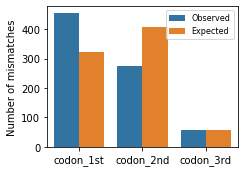

In [13]:
### Normalized by NeCE counts
tmp_result = pd.DataFrame([[455.1,276.0,56.9],[180.00322704079585,225.64309937742385,31.93801373014568]]).T

def divide_by_column_sum(x):
    if isinstance(x, str):
        if x.strip() == "":
            return x
    return x / tmp_result[x.name].sum()


df = tmp_result.apply(divide_by_column_sum)

tmp_result = df*788

tmp_result.columns = ['Observed','Expected']
tmp_result['location'] = ['codon_1st','codon_2nd','codon_3rd']
tmp_result.sort_values("location",inplace=True)
tmp_melt = tmp_result.melt(id_vars='location')
tmp_melt.columns = ['location','type','count']

plt.figure(figsize=(3.5,2.5))
sns.barplot(x='location',y='count',hue='type',data=tmp_melt)
plt.legend(fontsize=8)
plt.xlabel("")
plt.ylabel("Number of mismatches")
plt.tight_layout()